In [ ]:
if __name__ == '__main__':


    model_path = '/media/hhy/data/code_results/MILs/MIL_MixedBags/ckp/net.ckpt50.pth'
    net = Attention()
    inference_path = '/media/hhy/data/USdata/MergePhase1/test_0.3/test'
    pre_transform = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor()
        ])
    A = inferencer(model_path,net,inference_path, pre_transform)
    A.inference()
    A.stats()
    '''
    for i in range (len(A.total_weights)):
        print('Predicted label is {}'.format(A.pred_label[i].item()))
        print('Weights are {}'.format(A.total_weights[i].squeeze(-2).tolist()))
    #print(A.total_weights)
    '''

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from models.attentionMIL import Attention, GatedAttention, MIL
from data.PatientBags import PatientBags
from data.ruijin import RuijinBags
from data.bag import BMBags
from data.BMDataset import BMDataset
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt 
import pandas as pd 


In [43]:
class inferencer (object):
    def __init__(self, model_path, net, fold, inference_path):
        
        self.model = net.cuda()
        temp = torch.load(model_path)['net']
        self.model.load_state_dict(temp)
        pre_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        label_name = "手术淋巴结情况（0未转移；1转移）"
        self.inference_bag = RuijinBags(inference_path, fold, pre_transform,label_name)
        self.batch_size = 1
        self.inference_loader = DataLoader(self.inference_bag, batch_size=self.batch_size, shuffle=False, num_workers=8)

    def test(self):
        self.model.eval()
        pred = []
        prob = []
        g_truth = []
        total_weights = []
        replace_record = []
        for batch_idx, (data, label) in enumerate(tqdm(self.inference_loader, ascii=True, ncols = 60)):   # if label is unavailable, this line shoule be changed
            data = data.cuda()
            g_truth.append(label)
            with torch.no_grad():
                prob_label, predicted_label,_ = self.model.calculate_weights(data)
            # label or bag label?
            #target.append(bag_label.cpu().detach().numpy().ravel())
            pred.append(predicted_label.cpu().detach().numpy().ravel())
            prob.append(prob_label.cpu().detach().numpy().ravel())
        return g_truth, prob, pred

    def inference(self):
        self.g_truth, self.prob_label, self.pred_label = self.test()

In [48]:
net = Attention()
inference_path = '/remote-home/my/Ultrasound_CV/data/Ruijin/clean'

model_path4 = '/remote-home/my/hhy/Ultrasound_MIL/experiments/pln1_base4/ckp/net.ckpt50.pth'
model_path3 = '/remote-home/my/hhy/Ultrasound_MIL/experiments/pln1_base3/ckp/net.ckpt40.pth'
model_path2 = '/remote-home/my/hhy/Ultrasound_MIL/experiments/pln1_base2/ckp/net.ckpt20.pth'
model_path1 = '/remote-home/my/hhy/Ultrasound_MIL/experiments/pln1_base1/ckp/net.ckpt20.pth'
model_path0 = '/remote-home/my/hhy/Ultrasound_MIL/experiments/pln1_base0/ckp/net.ckpt40.pth'
path = [model_path0,model_path1,model_path2,model_path3,model_path4]

targets = []
probs = []

instance = inferencer(model_path0, net,[0] ,inference_path)
target, prob,_ = instance.test()
targets.extend(target)
probs.extend(prob)

'''
for idx, p in enumerate(path):
    instance = inferencer(p, net,[idx] ,inference_path)
    target, prob,_ = instance.test()
    targets.extend(target)
    probs.extend(prob)
'''

100%|#####################| 295/295 [00:10<00:00, 28.73it/s]


'\nfor idx, p in enumerate(path):\n    instance = inferencer(p, net,[idx] ,inference_path)\n    target, prob,_ = instance.test()\n    targets.extend(target)\n    probs.extend(prob)\n'

In [49]:
print(len(probs))

295


In [54]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(targets, probs)
#print(fpr,tpr,threshold)
roc_auc = metrics.auc(fpr, tpr)
print(fpr)
print(tpr)
print(roc_auc)

[0.         0.00406504 0.01626016 0.01626016 0.02439024 0.02439024
 0.06097561 0.06097561 0.08130081 0.08130081 0.1097561  0.1097561
 0.11382114 0.11382114 0.14227642 0.14227642 0.17886179 0.17886179
 0.19105691 0.19105691 0.20325203 0.20325203 0.21138211 0.21138211
 0.23577236 0.23577236 0.24390244 0.24390244 0.29268293 0.29268293
 0.30487805 0.30487805 0.32113821 0.32113821 0.32520325 0.32520325
 0.37398374 0.37398374 0.37804878 0.37804878 0.40650407 0.40650407
 0.41056911 0.41056911 0.42682927 0.42682927 0.45934959 0.45934959
 0.4796748  0.4796748  0.5203252  0.5203252  0.53252033 0.53252033
 0.54065041 0.54065041 0.55691057 0.55691057 0.59349593 0.59349593
 0.6097561  0.6097561  0.65447154 0.65447154 0.66666667 0.66666667
 0.67073171 0.67073171 0.68292683 0.68292683 0.69105691 0.69105691
 0.77642276 0.77642276 0.81707317 0.81707317 0.83333333 0.83333333
 0.86178862 0.86178862 0.86585366 0.86585366 0.87804878 0.87804878
 0.88211382 0.88211382 0.93495935 0.93495935 0.95528455 0.95528

In [53]:
import numpy as np
np.savetxt('fpr.txt',fpr)
np.savetxt('tpr.txt',tpr)

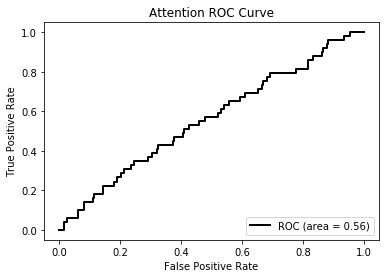

In [51]:
plt.plot(fpr, tpr, 'k-', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('Attention ROC Curve')
plt.legend(loc="lower right")
plt.show()